# Regression

## Imports

In [37]:
# data handling
import pandas as pd
import numpy as np
import time
from scipy import stats
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import shap
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
# interpretation
from sklearn.inspection import PartialDependenceDisplay

## Prepare Data

In [38]:
trainDF = pd.read_csv('../app/data/02_train.csv', sep=';')
testDF = pd.read_csv('../app/data/02_test.csv', sep=';')

In [39]:
trainDF.head()

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod,totalPrice
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686,347.0
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,133606,219943,3452460.0,470.8,2013,5,14,82499,136686,317.0
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,133606,219943,3452460.0,470.8,2012,12,29,18058,136686,301.5
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,81988,219943,3452460.0,470.8,2015,4,9,25725,136686,405.0
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,81988,219943,3452460.0,470.8,2017,12,7,82499,136686,670.0


In [40]:
columns = trainDF.columns.to_list()
print(columns)

['Lng', 'Lat', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'placeRank', 'town', 'districtPopulation', 'districtArea', 'tradeYear', 'tradeMonth', 'tradeDay', 'floorType', 'constructionTimePeriod', 'totalPrice']


### Outlier

In [41]:
print("lower lim:", trainDF["totalPrice"].quantile(0.01))
print("upper lim:", trainDF["totalPrice"].quantile(0.99))

lower lim: 84.0
upper lim: 1200.0


Text(0.5, 1.0, 'Boxplot: totalPrice testDF')

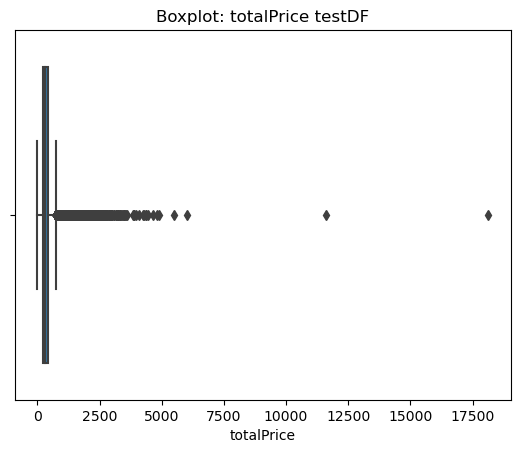

In [42]:
sns.boxplot(x=trainDF["totalPrice"])
plt.title("Boxplot: totalPrice testDF")

Text(0.5, 1.0, 'Boxplot: totalPrice trainDF')

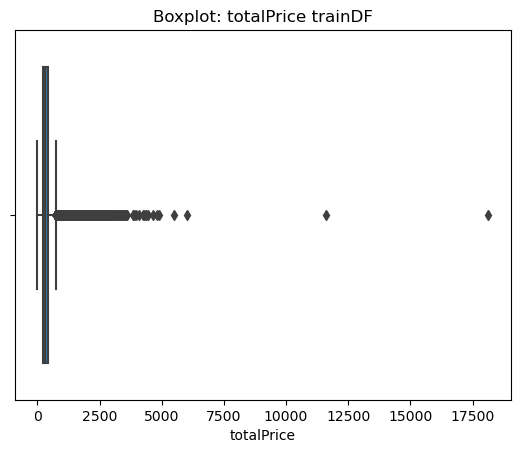

In [43]:
sns.boxplot(x=trainDF["totalPrice"])
plt.title("Boxplot: totalPrice trainDF")

In [44]:
# Remove outliers trainDF
threshhold = 5500
numOutliers = len(trainDF[trainDF["totalPrice"]>threshhold])
print(f"Quantitiy in trainDF where totalPrice > {threshhold}: {numOutliers}")
trainDF = trainDF[trainDF["totalPrice"]<threshhold]  # remove outlier
print(f"{numOutliers} removed")

Quantitiy in trainDF where totalPrice > 5500: 3
3 removed


In [45]:
# Remove outliers testDF
threshhold = 5500
numOutliers = len(testDF[testDF["totalPrice"]>threshhold])
print(f"Quantitiy in testDF where totalPrice > {threshhold}: {numOutliers}")
testDF = testDF[testDF["totalPrice"]<threshhold]  # remove outlier
print(f"{numOutliers} removed")

Quantitiy in testDF where totalPrice > 5500: 1
1 removed


Text(0.5, 1.0, 'Boxplot: totalPrice trainDF')

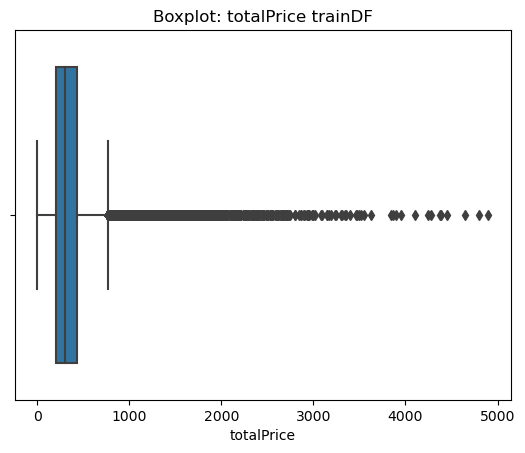

In [46]:
sns.boxplot(x=trainDF["totalPrice"])
plt.title("Boxplot: totalPrice trainDF")

Text(0.5, 1.0, 'Boxplot: totalPrice testDF')

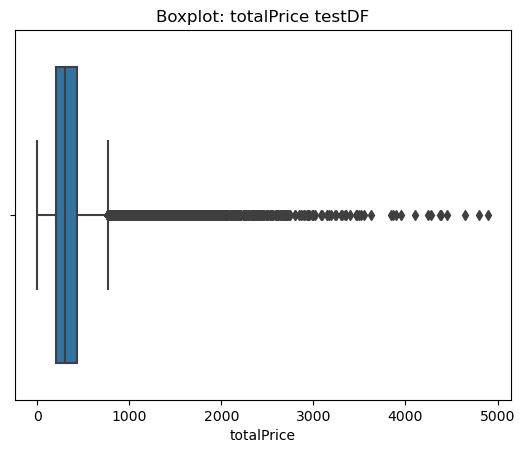

In [47]:
sns.boxplot(x=trainDF["totalPrice"])
plt.title("Boxplot: totalPrice testDF")

### Dataset split

In [48]:
X_train = trainDF.drop(['totalPrice'], axis=1)
y_train = trainDF['totalPrice']
X_test = testDF.drop(['totalPrice'], axis=1)
y_test = testDF['totalPrice']

In [49]:
X = X_train
y = y_train

In [50]:
X_train

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,communityAverage,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,39243.0,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,92516.0,133606,219943,3452460.0,470.8,2013,5,14,82499,136686
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,73113.0,133606,219943,3452460.0,470.8,2012,12,29,18058,136686
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,54612.0,81988,219943,3452460.0,470.8,2015,4,9,25725,136686
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,57510.0,81988,219943,3452460.0,470.8,2017,12,7,82499,136686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219938,116.451461,39.949365,57.49,2,1,1,1,6,118742,81641,...,72137.0,81988,219943,3452460.0,470.8,2012,12,15,48571,136686
219939,116.229624,39.915004,44.10,1,1,1,1,6,118742,81641,...,51471.0,81988,219943,3133469.0,426.0,2012,7,7,82499,16497
219940,116.310205,39.987486,138.14,3,2,1,2,16,58087,81641,...,79927.0,81988,219943,3133469.0,426.0,2011,12,5,44240,136686
219941,116.389264,39.886874,96.90,2,1,2,1,16,58087,81441,...,91507.0,4349,219943,1106214.0,46.5,2015,3,21,44240,136686


## ML

In [51]:
linearRegression = linear_model.LinearRegression()  # create linear regression
multipleLinearRegression = linearRegression.fit(X_train,y_train)
print('Coefficients: ', multipleLinearRegression.coef_)  # regression coefficients
print('intercept: ', multipleLinearRegression.intercept_)  # intercept

y_pred = multipleLinearRegression.predict(X_test)  # Make predictions using the testing set
print("\nMean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))  # The mean absolute error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))  # The mean squared error
print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, y_pred))  # The coefficient of determination: 1 is perfect prediction

Coefficients:  [-5.23173964e+01 -1.64519832e+00  3.82701074e+00  2.82216674e+00
  4.40023614e-01  7.21675198e+00 -1.46796853e-02 -5.11822201e-01
  9.67449997e-05  8.53742565e-04  2.20037973e-04  6.50032760e+01
  1.07180005e+01 -1.72994810e+01  5.65196977e+00  3.24044511e-02
  4.81997772e-03 -3.34812619e-05  4.97379915e-14  1.18285103e-05
 -4.55740541e-02  5.97909365e+01  3.95898302e+00  1.80907940e-01
  1.57744261e-04  5.88993203e-05]
intercept:  -114753.43945394605

Mean absolute error: 72.13
Mean squared error: 11526.22
Coefficient of determination (R^2): 0.78


In [52]:
y_test_pred = multipleLinearRegression.predict(X_test)
y_train_pred = multipleLinearRegression.predict(X_train)
rows = [
    [
        "test", 
        r2_score(y_test, y_test_pred),
        mean_absolute_error(y_test, y_test_pred), 
        mean_squared_error(y_test, y_test_pred), 
        np.sqrt(mean_squared_error(y_test, y_test_pred)),
        np.max(np.abs(y_test_pred - y_test))
    ],
    [
        "train", 
        r2_score(y_train, y_train_pred),
        mean_absolute_error(y_train, y_train_pred), 
        mean_squared_error(y_train, y_train_pred), 
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.max(np.abs(y_train_pred - y_train))
    ],
]
predDF_scores = pd.DataFrame(rows, columns=["Dataset", "R2", "MAE", "MSE", "RMSE", "Max_Error"])
predDF_scores.head()

,Dataset,R2,MAE,MSE,RMSE,Max_Error
0,test,0.777426,72.133605,11526.217031,107.360221,2562.877313
1,train,0.776830,71.987780,11595.920015,107.684354,3156.611297


In [53]:
# DF with predictions and deviation
predDF = X_test
predDF["totalPrice"] = y_test
predDF["prediction"] = y_pred
predDF["deviation"] = abs(predDF["totalPrice"] - predDF["prediction"])
predDF.head()

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod,totalPrice,prediction,deviation
0,116.432684,40.077562,104.02,2,1,1,1,6,118742,81441,...,2269487.0,1430.0,2015,11,21,82499,52625,237.5,295.746879,58.246879
1,116.432684,40.077562,102.27,2,1,1,1,20,58087,81641,...,2269487.0,1430.0,2013,7,27,82499,52625,210.0,164.839061,45.160939
2,116.438800,40.054941,53.00,2,1,1,2,17,41617,81441,...,3452460.0,470.8,2016,10,19,44240,52625,462.0,409.181436,52.818564
3,116.364866,39.964032,64.90,2,1,1,1,6,118742,81441,...,1106214.0,46.5,2016,7,5,82499,16497,390.0,405.995054,15.995054
4,116.364028,39.870465,69.10,2,2,1,1,6,118742,53150,...,1106214.0,46.5,2016,2,22,25725,136686,246.0,327.879022,81.879022


In [54]:
predDF["totalPrice"].describe()

count    94261.000000
mean       349.067226
std        227.566665
min          0.100000
25%        204.600000
50%        294.000000
75%        425.000000
max       4475.000000
Name: totalPrice, dtype: float64

In [55]:
predDF["prediction"].describe()

count    94261.000000
mean       349.187807
std        201.095319
min       -486.635001
25%        217.518261
50%        331.675910
75%        456.105841
max       2596.933635
Name: prediction, dtype: float64

In [56]:
predDF["deviation"].describe()

count    94261.000000
mean        72.133605
std         79.517464
min          0.000186
25%         26.456581
50%         54.356912
75%         92.737533
max       2562.877313
Name: deviation, dtype: float64

## Visualization & Interpretation

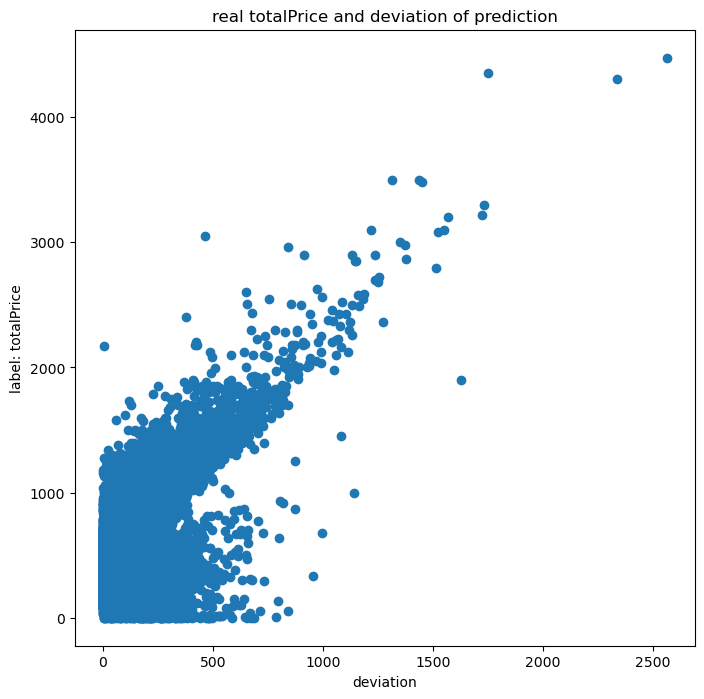

In [74]:
plt.figure(figsize=(8,8))
plt.scatter(predDF["deviation"], predDF["totalPrice"])
plt.title("real totalPrice and deviation of prediction")
plt.xlabel("deviation")
plt.ylabel("label: totalPrice")
plt.show()

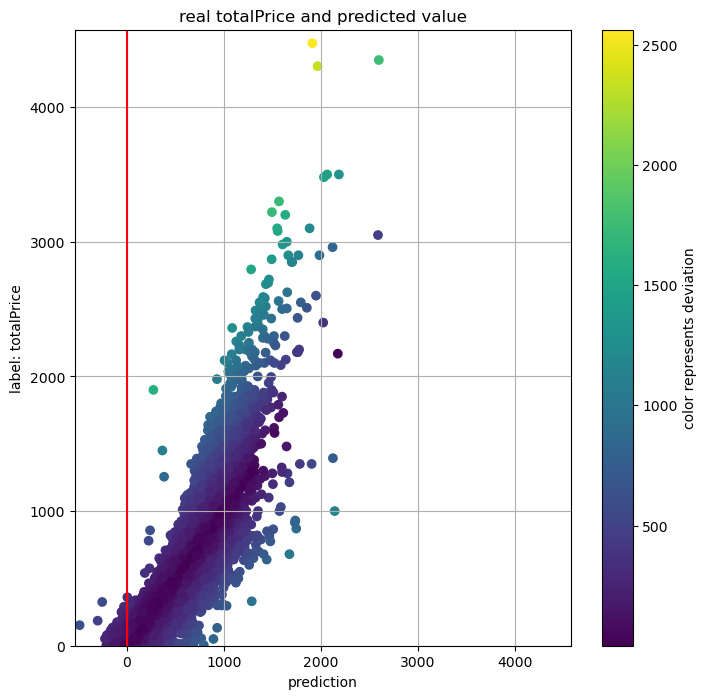

In [73]:
plt.figure(figsize=(8,8))
plt.scatter(predDF["prediction"], predDF["totalPrice"], c=predDF["deviation"])
plt.axvline(x=0, color="red")
plt.title("real totalPrice and predicted value")
plt.xlabel("prediction")
plt.ylabel("label: totalPrice")
plt.xlim((predDF["prediction"].min()-50,predDF["totalPrice"].max()+100))
plt.ylim((0,predDF["totalPrice"].max()+100))
plt.colorbar(label='color represents deviation')
plt.grid()
plt.show()

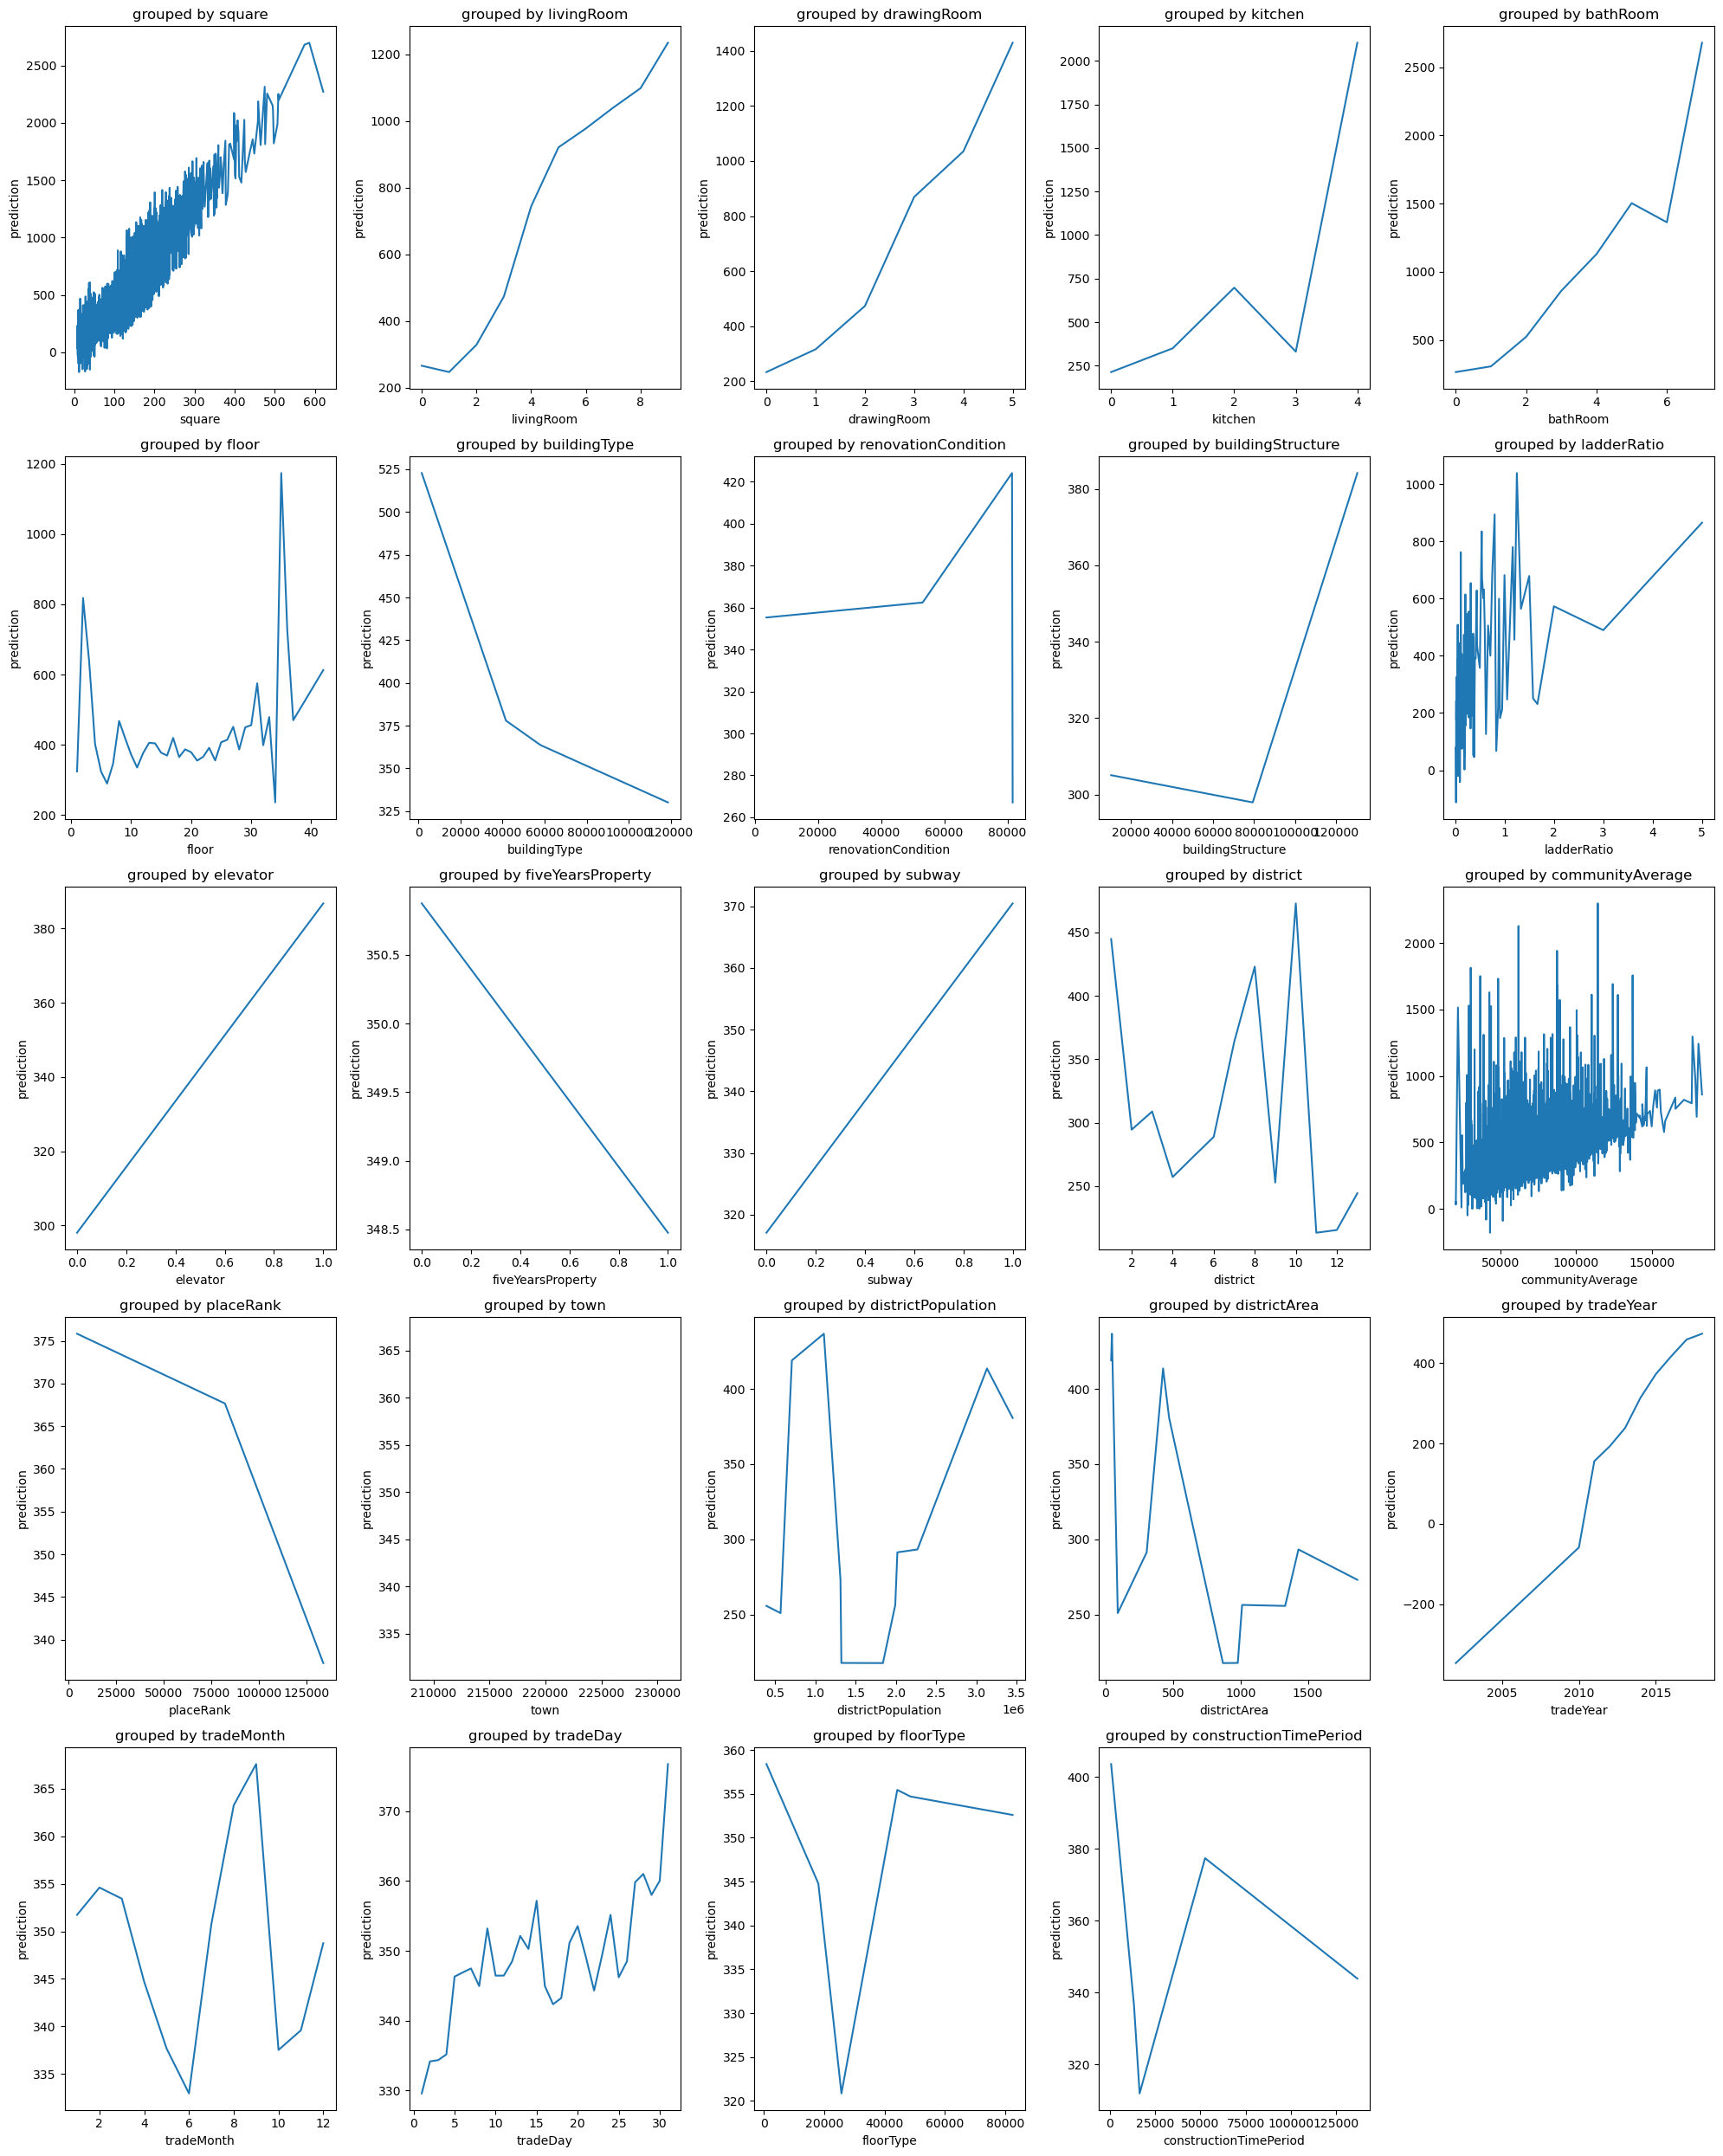

In [ ]:
columns=['square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'buildingType', 'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'placeRank', 'town', 'districtPopulation', 'districtArea', 'tradeYear', 'tradeMonth', 'tradeDay', 'floorType', 'constructionTimePeriod']

plt.figure(figsize=(20,25))
i=0
for groupByFeature in columns:
    i+=1
    plt.subplot(5,5,i)
    plt.plot(predDF.groupby([groupByFeature]).mean()["prediction"])
    plt.title(f"grouped by {groupByFeature}")
    plt.xlabel(groupByFeature)
    plt.ylabel("prediction")
plt.tight_layout()
plt.show()

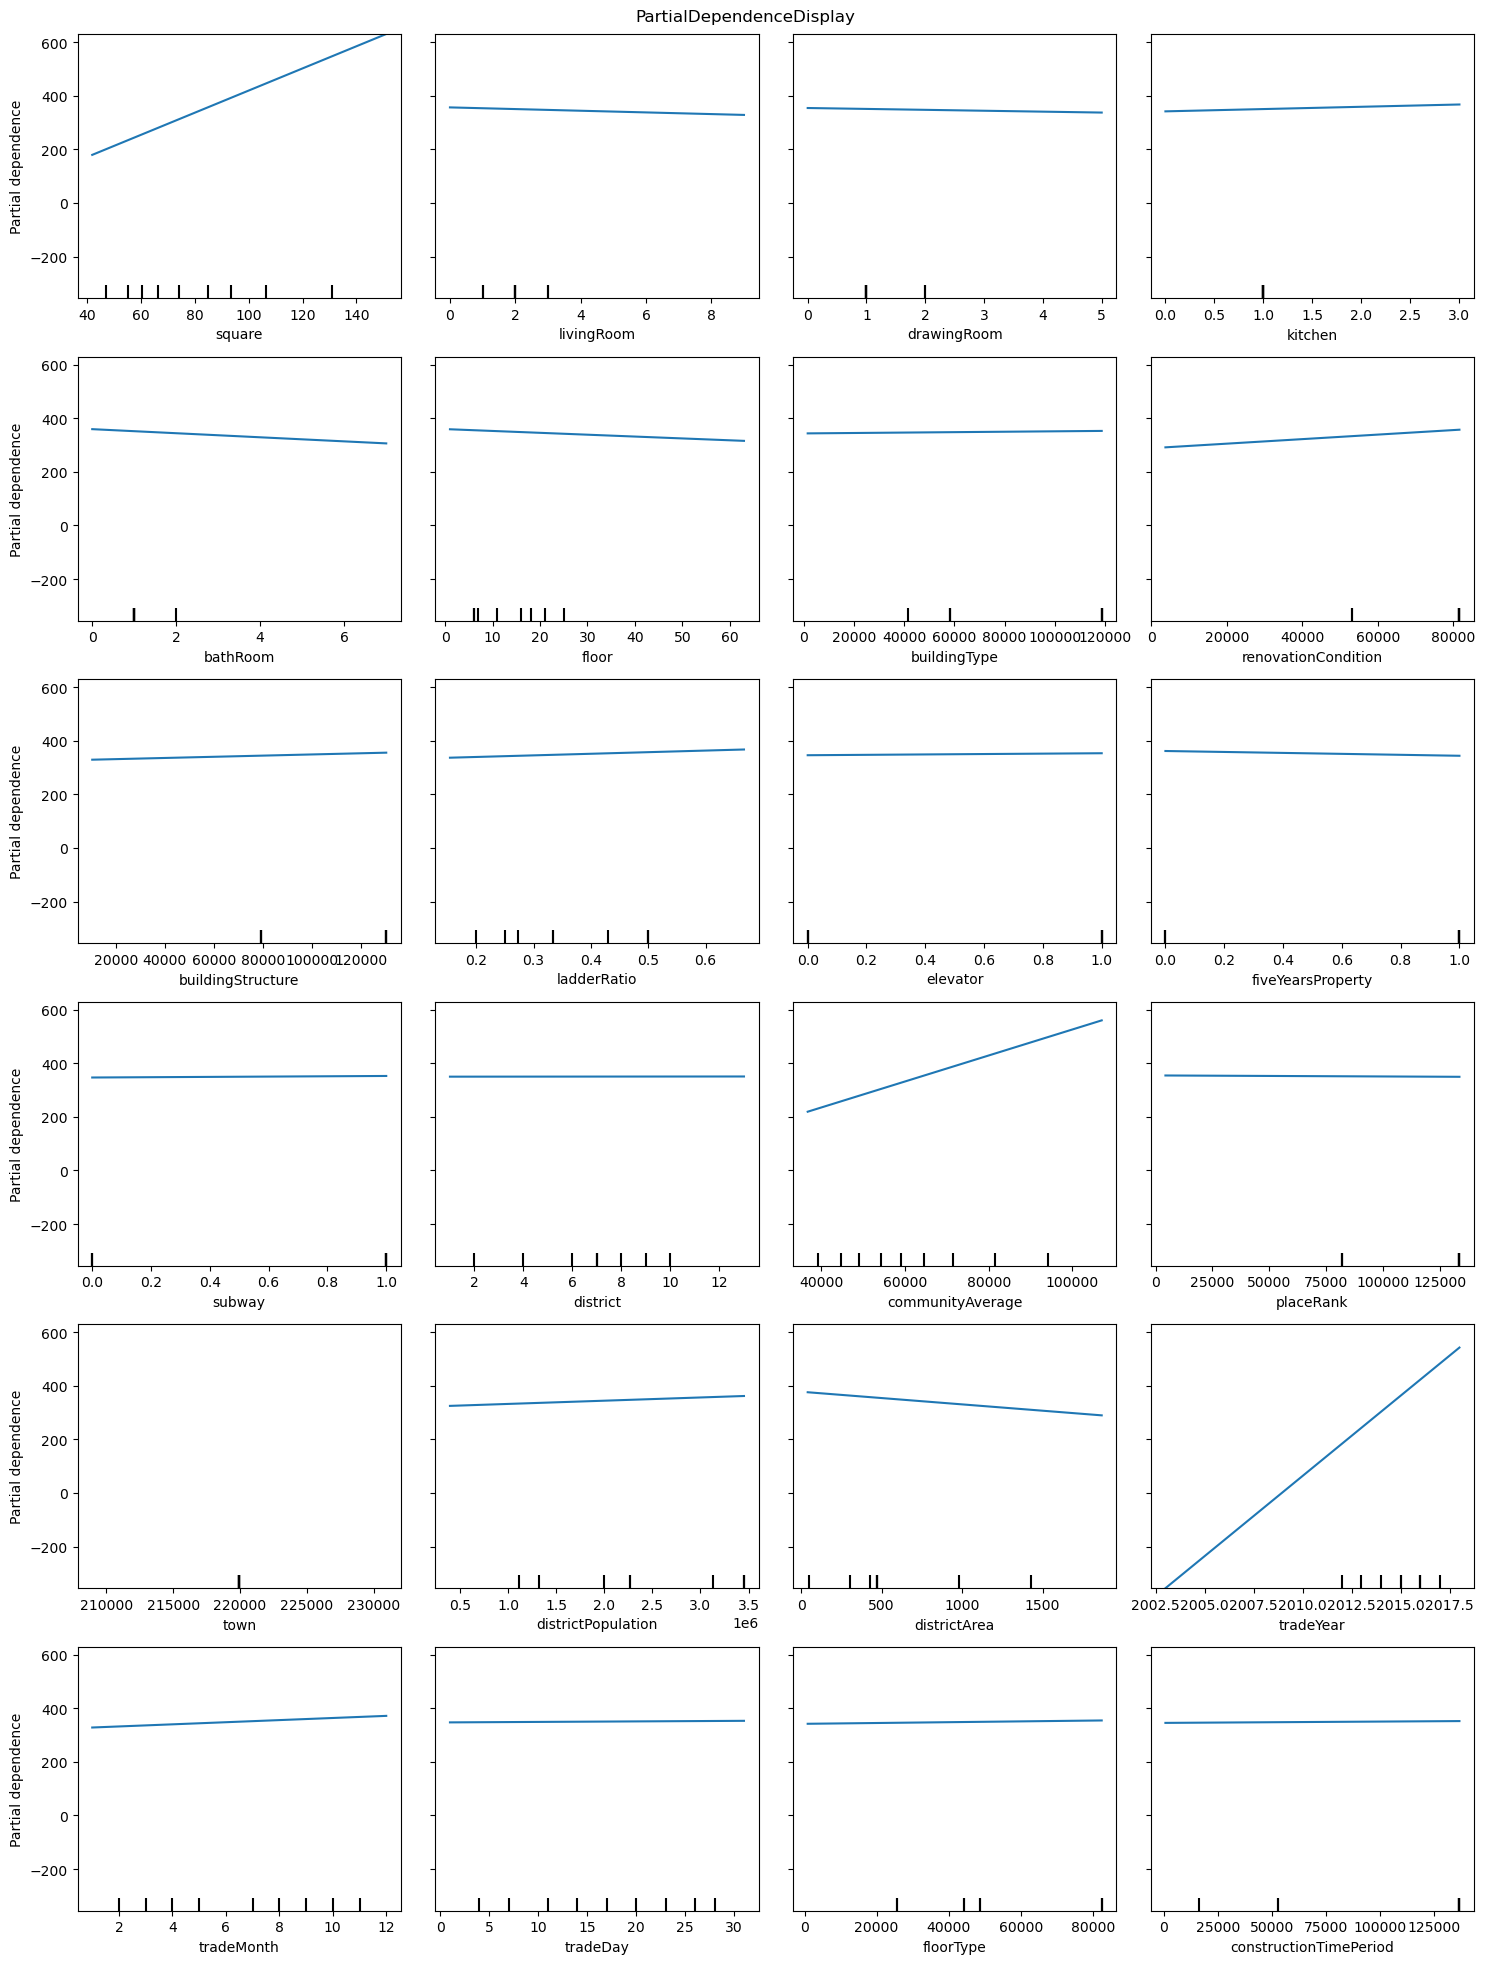

In [ ]:
n_cols = 4
n_rows = 6
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,20))
PartialDependenceDisplay.from_estimator(multipleLinearRegression, X_train, columns, ax=ax, n_cols=n_cols)
fig.suptitle("PartialDependenceDisplay")
fig.tight_layout(rect=[0, 0, 1, 0.99])
fig.show()

src: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [ ]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(multipleLinearRegression.predict, X_train)
shap_values = explainer(X_train)

Permutation explainer: 219944it [47:48, 76.41it/s]                             


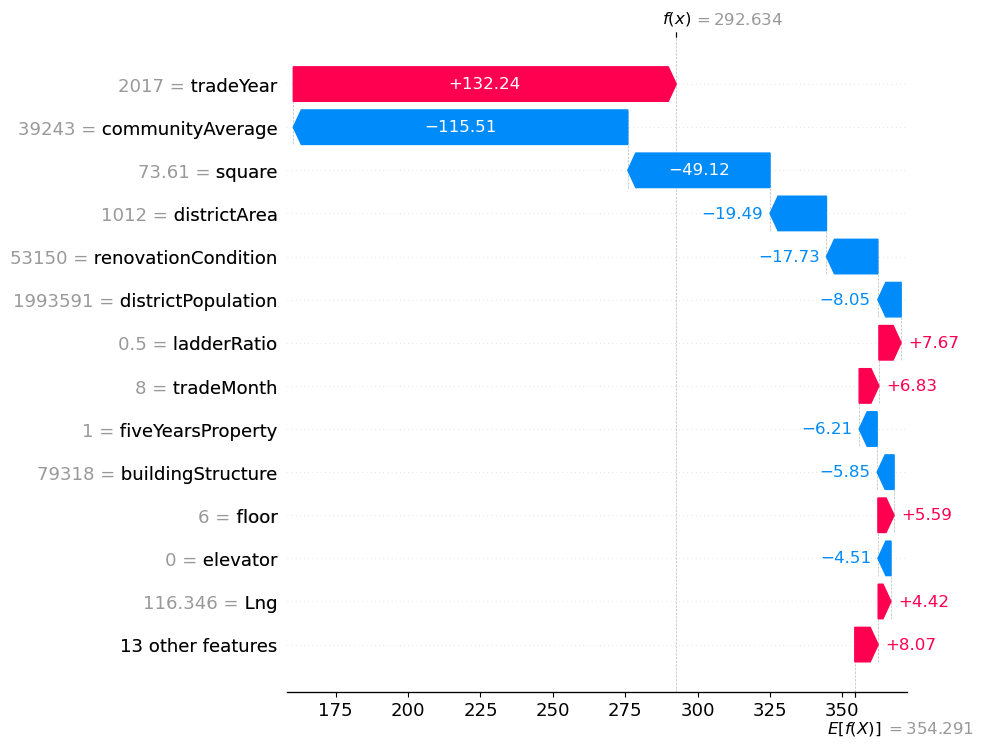

In [ ]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[0], max_display=14)

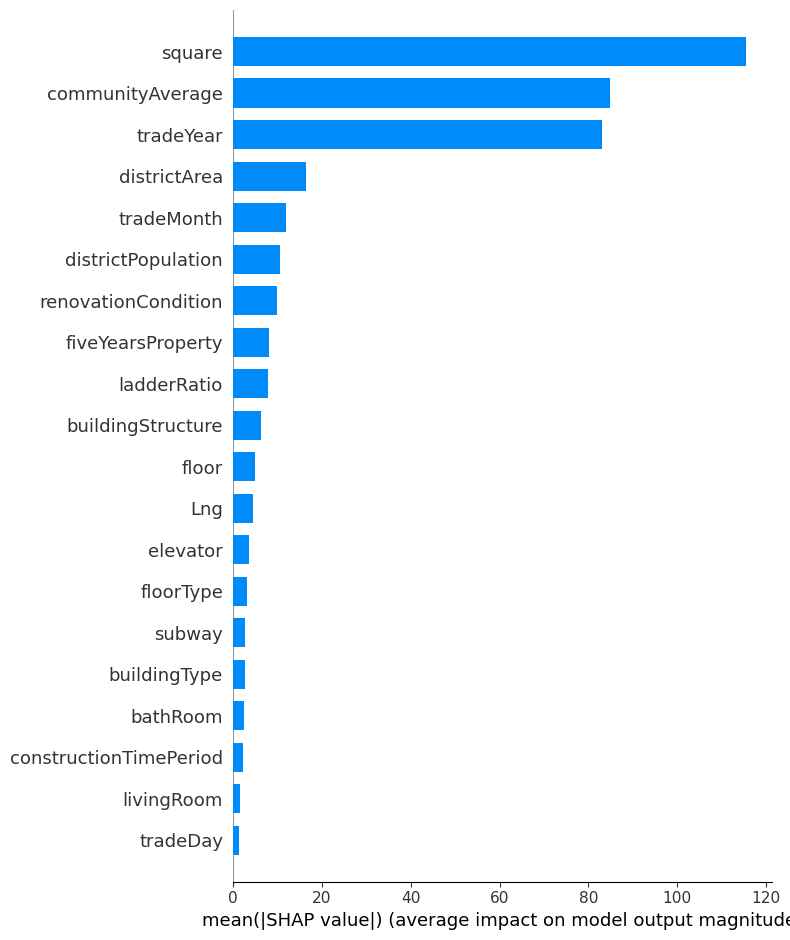

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

## ML after Interpretation

> After looking into the interpretation plots we can see, that we can achieve almost the same accuracy with only a few features

In [ ]:
columns_after_interpretation = ["square", "renovationCondition", "communityAverage", "tradeYear", "districtArea"]

In [ ]:
linearRegression = linear_model.LinearRegression()  # create linear regression
multipleLinearRegression = linearRegression.fit(X_train[columns_after_interpretation],y_train)
print('Coefficients: ', multipleLinearRegression.coef_)  # regression coefficients
print('intercept: ', multipleLinearRegression.intercept_)  # intercept

y_pred = multipleLinearRegression.predict(X_test[columns_after_interpretation])  # Make predictions using the testing set
print("\nMean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))  # The mean absolute error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))  # The mean squared error
print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, y_pred))  # The coefficient of determination: 1 is perfect prediction

Coefficients:  [ 4.11058085e+00  8.90505731e-04  4.98909931e-03  5.88709883e+01
 -4.03649620e-02]
intercept:  -118965.03855708802

Mean absolute error: 74.04
Mean squared error: 12209.71
Coefficient of determination (R^2): 0.77
